# Lyft: Working with Map API

This is a quick tutorial to show the different underlying concepts behind HD map from Lyft dataset. After this short tutorial, you should be able to understand the underlying concepts as well as how to query for different map layers. Feel free to contribute visualization for each layer in this notebook.

In [1]:
!pip install --upgrade pip
!pip install pymap3d==2.1.0
!pip install -U l5kit

     |████████████████████████████████| 1.5 MB 403 kB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 20.2.1
    Uninstalling pip-20.2.1:
      Successfully uninstalled pip-20.2.1
  Created wheel for pymap3d: filename=pymap3d-2.1.0-py3-none-any.whl size=37449 sha256=2949651fef5baa8cf0ab5742cbfe3472ad99a07aa9263891177948cc7330b61d
  Stored in directory: /root/.cache/pip/wheels/07/c5/26/fea218a784fb6a7bdacdafd4a1019d8195f02f31a0ea4be35e
Successfully built pymap3d
     |████████████████████████████████| 81 kB 378 kB/s eta 0:00:011
     |████████████████████████████████| 1.3 MB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 6.6 MB 7.3 MB/s eta 0:00:01
     |████████████████████████████████| 62 kB 857 kB/s  eta 0:00:01
     |████████████████████████████████| 3.3 MB 9.7 MB/s eta 0:00:01
     |████████████████████████████████| 42.8 MB 9.5 MB/s eta 0:00:011
     |████████████████████████████████| 3.8 MB 60.2 MB/s eta 0:00:01


  Created wheel for transforms3d: filename=transforms3d-0.3.1-py3-none-any.whl size=59372 sha256=f0932ce06023f2ca215cd6696fc31f94dab700ed4ad6dd771c088a30342afa79
  Stored in directory: /root/.cache/pip/wheels/b5/b7/93/8985551f83720ce37548a5b543c75380bb707955a9c2c5d28c
  Created wheel for zarr: filename=zarr-2.4.0-py3-none-any.whl size=127066 sha256=cb33a10a5755dfc968cfdab73cfd87df0d5057d97332204052a0f70a1057ed6a
  Stored in directory: /root/.cache/pip/wheels/0e/64/be/786ebbe8f1da63dc8a03214c610731e12c33f162727c374851
  Created wheel for ptable: filename=PTable-0.9.2-py3-none-any.whl size=22907 sha256=87b2b62d69486ebb0a9d090a101cbcf2abf9bddcde9b458cef158231d824f430
  Stored in directory: /root/.cache/pip/wheels/33/df/2f/674985b3f8a2de3f96357d1eadef5110f74fa91b3785e52a54
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5035 sha256=94eae8413ab6fe96979d2c8406bed0d9ce92d026a300d7f3a5d676bada4d6c3e
  Stored in directory: /root/.cache/pip/wheels/12/1c/38/0def51e15

In [2]:
import numpy as np
import l5kit, os
import matplotlib.pyplot as plt
from l5kit.rasterization import build_rasterizer
from l5kit.configs import load_config_data
from l5kit.visualization import draw_trajectory, TARGET_POINTS_COLOR
from l5kit.geometry import transform_points
from tqdm import tqdm
from collections import Counter
from l5kit.data import PERCEPTION_LABELS
from prettytable import PrettyTable
# set env variable for data
os.environ["L5KIT_DATA_FOLDER"] = "../input/lyft-motion-prediction-autonomous-vehicles"
# get config
cfg = load_config_data("../input/lyft-config-files/visualisation_config.yaml")

## Load The Dataset

In [3]:
from l5kit.data import ChunkedDataset, LocalDataManager
from l5kit.dataset import EgoDataset, AgentDataset
dm = LocalDataManager()
dataset_path = dm.require(cfg["val_data_loader"]["key"])
zarr_dataset = ChunkedDataset(dataset_path)
zarr_dataset.open()

## Load the MapAPI

In [5]:
from l5kit.data.map_api import MapAPI
from l5kit.rasterization.rasterizer_builder import _load_metadata

semantic_map_filepath = dm.require(cfg["raster_params"]["semantic_map_key"])
dataset_meta = _load_metadata(cfg["raster_params"]["dataset_meta_key"], dm)
world_to_ecef = np.array(dataset_meta["world_to_ecef"], dtype=np.float64)

map_api = MapAPI(semantic_map_filepath, world_to_ecef)

In [45]:
MAP_LAYERS = ["junction", "node", "segment", "lane"]


def element_of_type(elem, layer_name):
    return elem.element.HasField(layer_name)


def get_elements_from_layer(map_api, layer_name):
    return [elem for elem in map_api.elements if element_of_type(elem, layer_name)]


class MapRenderer:
    
    def __init__(self, map_api):
        self._color_map = dict(drivable_area='#a6cee3',
                               road_segment='#1f78b4',
                               road_block='#b2df8a',
                               lane='#474747')
        self._map_api = map_api
    
    def render_layer(self, layer_name):
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_axes([0, 0, 1, 1])
        
    def render_lanes(self):
        all_lanes = get_elements_from_layer(self._map_api, "lane")
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_axes([0, 0, 1, 1])
        for lane in all_lanes:
            self.render_lane(ax, lane)
        return fig, ax
        
    def render_lane(self, ax, lane):
        coords = self._map_api.get_lane_coords(MapAPI.id_as_str(lane.id))
        self.render_boundary(ax, coords["xyz_left"])
        self.render_boundary(ax, coords["xyz_right"])
        
    def render_boundary(self, ax, boundary):
        xs = boundary[:, 0]
        ys = boundary[:, 1] 
        ax.plot(xs, ys, color=self._color_map["lane"], label="lane")
        
        

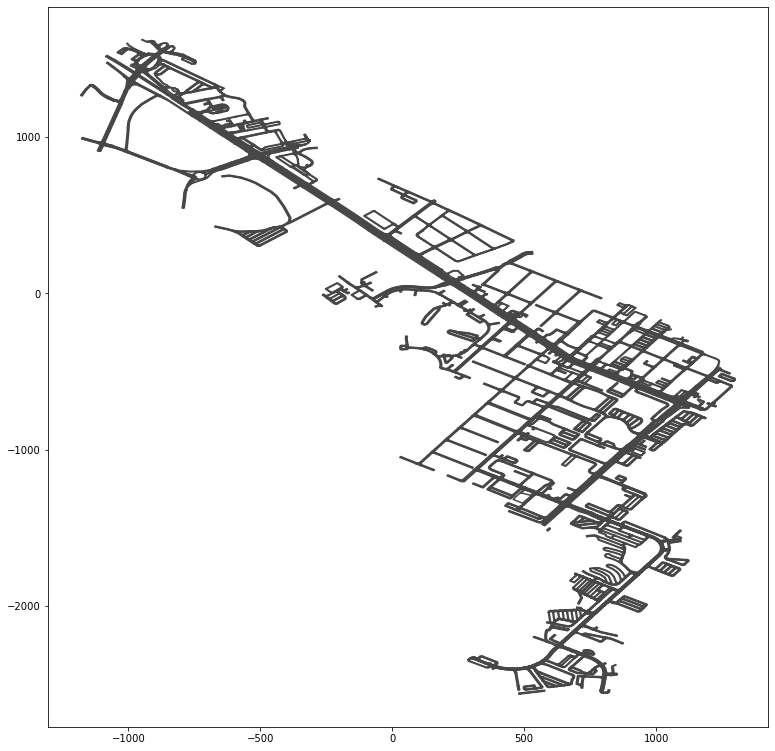

In [48]:
renderer = MapRenderer(map_api)
fig, ax = renderer.render_lanes()

### There are 7 types of map elements:

- Junction
- RoadNetworkSegment
- RoadNetworkNode
- Lane
- TrafficControlElement
- SegmentSequence 
- AnnotatedShape 

Let's dive into each one.

## Junction

Junction is conceptually a "big" intersection. This can consist of multiple smaller "intersections" which could be lane merges.

In [6]:
def is_junction(elem, map_api):
    return elem.element.HasField("junction")

def get_junctions(map_api):
    return [elem for elem in map_api.elements if is_junction(elem, map_api)]

all_junctions = get_junctions(map_api)
all_junctions[0]

id {
  id: "fKDq"
}
element {
  junction {
    road_network_nodes {
      id: "Igh/"
    }
    road_network_nodes {
      id: "nF79"
    }
    traffic_control_elements {
      id: "sAvc"
    }
    traffic_control_elements {
      id: "Vg0Q"
    }
    lanes {
      id: "JOiU"
    }
  }
}
bounding_box {
  south_west {
    lat_e7: 374077634
    lng_e7: -1221449279
  }
  north_east {
    lat_e7: 374077634
    lng_e7: -1221449279
  }
}

## Road Network Node

Road network node are map intersection connecting several road segments. Each road network node belongs to one junction. If we think about the road network as a graph, this will be a node in the graph where a road segment would be an edge connecting two nodes.

In [7]:
def is_node(elem, map_api):
    return elem.element.HasField("node")

def get_nodes(map_api):
    return [elem for elem in map_api.elements if is_junction(elem, map_api)]

all_nodes = get_nodes(map_api)
all_nodes[0]

id {
  id: "fKDq"
}
element {
  junction {
    road_network_nodes {
      id: "Igh/"
    }
    road_network_nodes {
      id: "nF79"
    }
    traffic_control_elements {
      id: "sAvc"
    }
    traffic_control_elements {
      id: "Vg0Q"
    }
    lanes {
      id: "JOiU"
    }
  }
}
bounding_box {
  south_west {
    lat_e7: 374077634
    lng_e7: -1221449279
  }
  north_east {
    lat_e7: 374077634
    lng_e7: -1221449279
  }
}

## Road Network Segment

This is the drivable surface connecting two intersections (nodes). If we think about the road network as a graph, and each intersection as a node, then a road segment is an edge connecting two nodes.

In [8]:
def is_segment(elem, map_api):
    return elem.element.HasField("segment")

def get_segments(map_api):
    return [elem for elem in map_api.elements if is_segment(elem, map_api)]

all_segments = get_segments(map_api)
all_segments[0]

id {
  id: "8fcf"
}
element {
  segment {
    vertices {
      lat_e7: 374290704
      lng_e7: -1221505606
      altitude_cm: -1864
    }
    vertices {
      lat_e7: 374291434
      lng_e7: -1221505030
      altitude_cm: -1877
    }
    vertices {
      lat_e7: 374291658
      lng_e7: -1221504853
      altitude_cm: -1866
    }
    start_node {
      id: "qk3O"
    }
    end_node {
      id: "wn6T"
    }
    forward_lane_set {
      num_driving_lanes: 1
      bike_lane_access: SHARED
    }
    road_class: SERVICE
    travel_direction: TWO_WAY
    lanes {
      id: "1ENT"
    }
    lanes {
      id: "YFNT"
    }
    backward_lane_set {
      num_driving_lanes: 1
      bike_lane_access: SHARED
    }
  }
}
bounding_box {
  south_west {
    lat_e7: 374290704
    lng_e7: -1221505606
  }
  north_east {
    lat_e7: 374291658
    lng_e7: -1221504853
  }
}

## Lane

Each road segment is built from multiple lanes. It is worth noting that the structure of lane allows for one to traverse the lane graph by using lane.lanes_ahead and lane.adjacent_lane_change_left  and lane.adjacent_lane_change_right

In [14]:
def is_lane(elem, map_api):
    return elem.element.HasField("lane")

def get_lanes(map_api):
    return [elem for elem in map_api.elements if is_lane(elem, map_api)]

all_lanes = get_lanes(map_api)
all_lanes[0]

id {
  id: "362i"
}
element {
  lane {
    parent_segment_or_junction {
      id: "Hp60"
    }
    geo_frame {
      origin {
        lat_e7: 374108709
        lng_e7: -1221462192
      }
    }
    left_boundary {
      vertex_deltas_x_cm: 16397
      vertex_deltas_x_cm: 663
      vertex_deltas_x_cm: 71
      vertex_deltas_x_cm: 692
      vertex_deltas_x_cm: 448
      vertex_deltas_x_cm: 405
      vertex_deltas_x_cm: 342
      vertex_deltas_x_cm: 582
      vertex_deltas_x_cm: 768
      vertex_deltas_x_cm: 21
      vertex_deltas_x_cm: 51
      vertex_deltas_x_cm: 548
      vertex_deltas_x_cm: 211
      vertex_deltas_x_cm: 148
      vertex_deltas_x_cm: 21
      vertex_deltas_x_cm: 17
      vertex_deltas_x_cm: 88
      vertex_deltas_x_cm: 368
      vertex_deltas_x_cm: 1362
      vertex_deltas_x_cm: 726
      vertex_deltas_y_cm: 54912
      vertex_deltas_y_cm: -420
      vertex_deltas_y_cm: -46
      vertex_deltas_y_cm: -439
      vertex_deltas_y_cm: -283
      vertex_deltas_y_cm: -257
   

## Traffic Control Element

Traffic signals, e.g. traffic lights or individual "faces" of traffic lights, stop signs, yield signs, etc. controlling the exit from the lane onto one of the lanes ahead.

In [10]:
def is_traffic_element(elem, map_api):
    return elem.element.HasField("traffic_control_element")

def get_traffic_elements(map_api):
    return [elem for elem in map_api.elements if is_traffic_element(elem, map_api)]

all_traffic_elements = get_traffic_elements(map_api)
all_traffic_elements[0]

id {
  id: "jxu9"
}
element {
  traffic_control_element {
    geo_frame {
      origin {
        lat_e7: 374268989
        lng_e7: -1221485432
      }
    }
    points_x_deltas_cm: 141
    points_x_deltas_cm: 0
    points_x_deltas_cm: -3652
    points_x_deltas_cm: 0
    points_x_deltas_cm: 127
    points_x_deltas_cm: 3652
    points_y_deltas_cm: -67
    points_y_deltas_cm: 0
    points_y_deltas_cm: -5754
    points_y_deltas_cm: 0
    points_y_deltas_cm: -80
    points_y_deltas_cm: 5754
    points_z_deltas_cm: -2129
    points_z_deltas_cm: 0
    points_z_deltas_cm: 13
    points_z_deltas_cm: 0
    points_z_deltas_cm: -8
    points_z_deltas_cm: -8
    parking_zone {
    }
  }
}
bounding_box {
  south_west {
    lat_e7: 374263672
    lng_e7: -1221489398
    altitude_cm: -2132
  }
  north_east {
    lat_e7: 374268928
    lng_e7: -1221485129
    altitude_cm: -2116
  }
}

## Segment Sequence

An ordered collection of connected segments, indicating that it is either illegal, or conversely, the only option, to proceed along that path when starting from the first segment. Typically used to represent turn restrictions, with 2 or more segments in the sequence. For complicated intersections, the sequence can have more segments, with the intermediate ones just joining nodes that are all in the intersection. In some instances, it is more concise to represent the only path that can be taken, as opposed to all the paths that cannot be taken. The reason for keeping orientation  is to present the directionality; one example is where a turn restriction is on the same from and to segment, and the restriction is only on one side of the segment. With only list of segments, it's not possible to represent this restriction, as we have to distinguish one end from the other end.

But the small version of the dataset doesn't seem to have any segment sequences.

In [11]:
def is_segment_sequence(elem, map_api):
    return elem.element.HasField("segment_sequence")

def get_segment_sequences(map_api):
    return [elem for elem in map_api.elements if is_segment_sequence(elem, map_api)]

all_segment_sequences = get_segment_sequences(map_api)
print(len(all_segment_sequences))

0


## Annotated Shape

Represents polygonal data that are either physical (e.g. buildings) or imaginary (e.g. political boundaries) and their associated properties.

In [12]:
def is_annotated_shape(elem, map_api):
    return elem.element.HasField("annotated_shape")

def get_annotated_shapes(map_api):
    return [elem for elem in map_api.elements if is_annotated_shape(elem, map_api)]

all_annotated_shapes = get_annotated_shapes(map_api)
all_annotated_shapes[0]

id {
  id: "fOX9"
}
element {
  annotated_shape {
    multipolygon {
      polygons {
        shell_vertices {
          lat_e7: 374248539
          lng_e7: -1221480560
          altitude_cm: -2141
        }
        shell_vertices {
          lat_e7: 374249718
          lng_e7: -1221480560
          altitude_cm: -2139
        }
        shell_vertices {
          lat_e7: 374250294
          lng_e7: -1221481648
          altitude_cm: -2137
        }
        shell_vertices {
          lat_e7: 374249484
          lng_e7: -1221482341
          altitude_cm: -2137
        }
        shell_vertices {
          lat_e7: 374248539
          lng_e7: -1221480560
          altitude_cm: -2141
        }
      }
    }
    drivable_surface_prior {
    }
  }
}
bounding_box {
  south_west {
    lat_e7: 374248539
    lng_e7: -1221482341
    altitude_cm: 0
  }
  north_east {
    lat_e7: 374250294
    lng_e7: -1221480560
    altitude_cm: 0
  }
}